Based on " Real-time Convolutional Neural Networks for Emotion and Gender Classification "

https://arxiv.org/pdf/1710.07557.pdf

Reference : https://appliedmachinelearning.blog/2018/11/28/demonstration-of-facial-emotion-recognition-on-real-time-video-using-cnn-python-keras/

Data set : The data consists of 48x48 pixel grayscale images of faces.
    
The faces have been automatically registered so that the face is more or less centered and
occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression
in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).



In [1]:
#when learning colab
#!pip install opendatasets
#import opendatasets as od
#od.download("https://www.kaggle.com/datasets/nicolejyt/facialexpressionrecognition")

In [3]:
import pandas as pd

In [4]:
import cv2

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

In [6]:
#FILE_PATH = '/content/facialexpressionrecognition/fer2013.csv' #colab
FILE_PATH = '/kaggle/input/facialexpressionrecognition/fer2013.csv'

In [7]:
image_size = (48, 48)

In [8]:
data = pd.read_csv(FILE_PATH)

In [9]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [10]:
pixels = data['pixels'].tolist()

In [11]:
width, height = image_size

In [12]:
# load images and emotions
faces = []
import numpy as np
for p in pixels:
    face = [int(pix) for pix in p.split(' ')]
    face = np.asarray(face).reshape(width, height)
    face = cv2.resize(face.astype('uint8'), image_size)
    faces.append(face.astype('float32'))

In [13]:
len(faces)

35887

In [14]:
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)

In [15]:
emotions = pd.get_dummies(data['emotion']).values
emotions.shape


(35887, 7)

In [16]:
# pre-process the images
def preprocess(x, v2=True):  # v2 to keep the image btw. -1 and 1
    x = x.astype('float32')
    x = x/255.0
    if v2:
        x = (x - 0.5)*2.0
    return x

In [17]:
faces = preprocess(faces)

In [18]:
#print('showing some sample training images')
#for image in np.arange(0,10):
#    cv2.namedWindow('some sample training images', cv2.WINDOW_NORMAL)
#    cv2.imshow('some sample training images',faces[image])
#    cv2.waitKey(500)
#    cv2.destroyAllWindows()

In [19]:

xtrain, xtest, ytrain, ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)


# CNN model : Mini Xception

In [20]:
from tensorflow.keras.callbacks import  ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation, Convolution2D, Conv2D, Dropout, AveragePooling2D, BatchNormalization, GlobalAveragePooling2D, Flatten, Input, MaxPooling2D, SeparableConv2D

In [23]:
from tensorflow.keras.models import Model

In [24]:
from tensorflow.keras.regularizers import l2

In [25]:
#parameters
import os

batch_size = 32
epochs = 100
image_shape = (48, 48, 1)
verbose = True
num_class = 7
patience = 50  # number of epochs with no improvement after which training will be stopped

base_path = '/kaggle/working/models/'
if not os.path.exists(base_path):
    os.mkdir(base_path)
l2_regularization = 0.01


In [26]:
data_generator = ImageDataGenerator(featurewise_center=False, featurewise_std_normalization=False, rotation_range=10,
                                    width_shift_range=0.1, height_shift_range=0.1, zoom_range=.1, horizontal_flip=True)

In [27]:
regularization = l2(l2_regularization)

In [28]:
# model
image_input = Input(image_shape)
x = Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), kernel_regularizer=regularization, use_bias=False)(image_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# module 1
# residual module
residual = Conv2D(filters=16, kernel_size=(1,1), strides=(2,2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)

# The change is here: passing the regularizer to depthwise_regularizer and pointwise_regularizer
x = SeparableConv2D(filters=16, kernel_size=(3,3), padding='same', depthwise_regularizer=regularization, pointwise_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(filters=16, kernel_size=(3,3), padding='same', depthwise_regularizer=regularization, pointwise_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = layers.add([x,residual])

# module 2
# residual module
residual = Conv2D(filters=32, kernel_size=(1,1), strides=(2,2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)

# The change is here: passing the regularizer to depthwise_regularizer and pointwise_regularizer
x = SeparableConv2D(filters=32, kernel_size=(3,3), padding='same', depthwise_regularizer=regularization, pointwise_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(filters=32, kernel_size=(3,3), padding='same', depthwise_regularizer=regularization, pointwise_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = layers.add([x,residual])

# module 3
# residual module
residual = Conv2D(filters=64, kernel_size=(1,1), strides=(2,2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)

# The change is here: passing the regularizer to depthwise_regularizer and pointwise_regularizer
x = SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', depthwise_regularizer=regularization, pointwise_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', depthwise_regularizer=regularization, pointwise_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = layers.add([x,residual])

# module 4
# residual module
residual = Conv2D(filters=128, kernel_size=(1,1), strides=(2,2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)

# The change is here: passing the regularizer to depthwise_regularizer and pointwise_regularizer
x = SeparableConv2D(filters=128, kernel_size=(3,3), padding='same', depthwise_regularizer=regularization, pointwise_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(filters=128, kernel_size=(3,3), padding='same', depthwise_regularizer=regularization, pointwise_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = layers.add([x,residual])

x = Conv2D(filters=num_class, kernel_size=(3,3), padding='same')(x)
x = GlobalAveragePooling2D()(x)

output = Activation('softmax', name='predictions')(x)

In [29]:
model = Model(image_input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 48, 48, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 46, 46, 8)      │             72 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 46, 46, 8)      │             32 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 46, 46, 8)      │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 44, 44, 8)      │            576 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 44, 44, 8)      │             32 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 44, 44, 8)      │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 44, 44, 16)     │            200 │ activation_1[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 44, 44, 16)     │             64 │ separable_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 44, 44, 16)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 44, 44, 16)     │            400 │ activation_2[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 44, 44, 16)     │             64 │ separable_conv2d_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 22, 22, 16)     │            128 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 22, 22, 16)     │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 22, 22, 16)     │             64 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)            

 Total params: 58,423 (228.21 KB)

 Trainable params: 56,951 (222.46 KB)

 Non-trainable params: 1,472 (5.75 KB)

In [30]:
early_stop = EarlyStopping(monitor='val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=int(patience/4), verbose=verbose)

trained_models_path = base_path + '_mini_XCEPTION'
model_names = trained_models_path + '.{epoch:02d}_{val_accuracy:.2f}.keras'
model_checkpoint = ModelCheckpoint(filepath=model_names, monitor='val_accuracy', verbose=verbose, save_best_only=True)

callbacks = [model_checkpoint,  early_stop, reduce_lr]

In [72]:
history = model.fit(
        data_generator.flow(xtrain, ytrain, batch_size=batch_size),
        initial_epoch=0, # added line
        epochs=epochs,
        verbose=verbose,
        callbacks=callbacks,
        validation_data=(xtest, ytest),
        validation_steps=len(xtest) // batch_size
    )

Epoch 1/100
895/898 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2832 - loss: 3.9982
Epoch 1: val_accuracy improved from -inf to 0.24714, saving model to /kaggle/working/models/_mini_XCEPTION.01_0.25.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 35s 25ms/step - accuracy: 0.2834 - loss: 3.9934 - val_accuracy: 0.2471 - val_loss: 4.2403 - learning_rate: 0.0010
Epoch 2/100
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4290 - loss: 1.7584
Epoch 2: val_accuracy did not improve from 0.24714
898/898 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.4290 - loss: 1.7582 - val_accuracy: 0.1372 - val_loss: 5.2560 - learning_rate: 0.0010
Epoch 3/100
894/898 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4743 - loss: 1.5490
Epoch 3: val_accuracy did not improve from 0.24714
898/898 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.4743 - loss: 1.5489 - val_accuracy: 0.1672 - val_loss: 30.8343 - learning_rate: 0.0010
Epoch 4/100
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4903 - loss: 1.

# Detecting emotions of a face in an image

In [97]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import imutils
import sys

In [114]:
detection_model_path = 'haarcascade_frontalface_default.xml'
emotion_recognition_model_path = '/kaggle/input/emotions/keras/default/1/_mini_xception.100_0.65.hdf5'
image_path = '/kaggle/input/test-set/istockphoto-1473203340-612x612.jpg'

In [115]:
face_detection = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [116]:
from tensorflow.keras.models import load_model
emotion_classifier = load_model(emotion_recognition_model_path, compile=False)
emotion_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [117]:
emotions = ['angry', 'disgust', 'scared', 'happy', 'sad', 'surprised', 'neutral']

In [118]:
color_frame = cv2.imread(image_path)
gray_frame = cv2.imread(image_path, 0)

In [119]:
color_frame.shape

(514, 612, 3)

In [120]:
detected_faces = face_detection.detectMultiScale(color_frame, scaleFactor=1.1, minNeighbors=5,
                                        minSize=(30,30), flags=cv2.CASCADE_SCALE_IMAGE)
print('Number of faces detected : ', len(detected_faces))

if len(detected_faces)>0:

    detected_faces = sorted(detected_faces, reverse=True, key=lambda x: (x[2]-x[0])*(x[3]-x[1]))[0] # if more than one faces
    (fx, fy, fw, fh) = detected_faces

    im = gray_frame[fy:fy+fh, fx:fx+fw]
    im = cv2.resize(im, (48,48))  # the model is trained on 48*48 pixel image
    im = im.astype("float")/255.0
    im = img_to_array(im)
    im = np.expand_dims(im, axis=0)

    preds = emotion_classifier.predict(im)[0]
    emotion_probability = np.max(preds)
    label = emotions[preds.argmax()]

    cv2.putText(color_frame, label, (fx, fy-10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    cv2.rectangle(color_frame, (fx, fy), (fx + fw, fy + fh),(0, 0, 255), 2)


cv2.imwrite('output.jpg', color_frame)


Number of faces detected :  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step


True

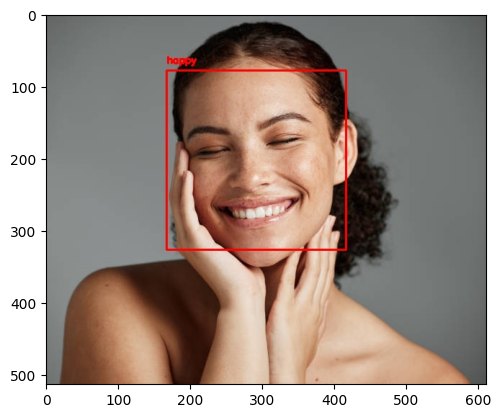

In [121]:
import matplotlib.pyplot as plt
from PIL import Image
np_image = np.array(Image.open('output.jpg'))
plt.imshow(np_image)

# Detecting emotions of faces in a video

In [ ]:
cv2.namedWindow('emotion_recognition')
#camera = cv2.VideoCapture(0)  ## uncomment to use your laptop camera
camera = cv2.VideoCapture('various_emotions.mp4')  # uncomment to read from a video file

sz = (int(camera.get(cv2.CAP_PROP_FRAME_WIDTH)),
        int(camera.get(cv2.CAP_PROP_FRAME_HEIGHT)))

fourcc = cv2.VideoWriter_fourcc(*'mpeg')

out = cv2.VideoWriter()
out.open('output_various_emotions.mp4',fourcc, 15, sz, True) # initialize the writer


# while True: # when reading from a video camera, use this while condition
while(camera.read()[0]):  # when reading from a video file, use this while condition
    color_frame = camera.read()[1]
    color_frame = imutils.resize(color_frame,width=min(720, color_frame.shape[1]))


    gray_frame = cv2.cvtColor(color_frame, cv2.COLOR_BGR2GRAY)
    detected_faces = face_detection.detectMultiScale(gray_frame,scaleFactor=1.1,minNeighbors=5,minSize=(30,30),flags=cv2.CASCADE_SCALE_IMAGE)


    canvas = np.zeros((250, 300, 3), dtype="uint8")
    frameClone = color_frame.copy()


    if len(detected_faces)>0:

        detected_faces = sorted(detected_faces, reverse=True, key=lambda x: (x[2]-x[0])*(x[3]-x[1]))[0] # if more than one faces
        (fx, fy, fw, fh) = detected_faces

        im = gray_frame[fy:fy+fh, fx:fx+fw]
        im = cv2.resize(im, (48,48))  # the model is trained on 48*48 pixel image
        im = im.astype("float")/255.0
        im = img_to_array(im)
        im = np.expand_dims(im, axis=0)

        preds = emotion_classifier.predict(im)[0]
        emotion_probability = np.max(preds)
        label = emotions[preds.argmax()]

        cv2.putText(color_frame, label, (fx, fy-10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
        cv2.rectangle(color_frame, (fx, fy), (fx + fw, fy + fh),(0, 0, 255), 2)


    for (i, (emotion, prob)) in enumerate(zip(emotions, preds)):
        # construct the label text
        text = "{}: {:.2f}%".format(emotion, prob * 100)
        w = int(prob * 300)

        cv2.rectangle(canvas, (7, (i * 35) + 5), (w, (i * 35) + 35), (0, 50, 100), -1)
        cv2.putText(canvas, text, (10, (i * 35) + 23), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 255), 1)
        cv2.putText(frameClone, label, (fx, fy - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (100, 150, 100), 2)
        cv2.rectangle(frameClone, (fx, fy), (fx + fw, fy + fh), (100, 100, 100), 2)

    out.write(frameClone)
    out.write(canvas)

    cv2.imshow('emotion_recognition', frameClone)
    cv2.imshow("Probabilities", canvas)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

camera.release()
out.release()
cv2.destroyAllWindows()